## Test Binary (Men's vs Women's) Model Accuracy
#### Also test whether similar watch recommendations are better (or worse)

In [1]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image

from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model, Model

%matplotlib inline

Using TensorFlow backend.


__Load Models__

In [2]:

watch_model = load_model('inceptionv3_binary_unfrozen_convos2_final.h5') 

In [3]:
watch_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, None, None, 2048)  21802784  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 0
Non-trainable params: 21,804,833
_________________________________________________________________


In [4]:
for layer in watch_model.layers[0].layers:
    layer.trainable = False

for layer in watch_model.layers:
    layer.trainable = False

In [5]:
layer_name = 'avg_pool'
watch_model_headless = Model(inputs=watch_model.input,
                                 outputs=watch_model.get_layer(layer_name).output)

In [6]:
watch_df = pd.read_csv('all_watch_info_with_indicators.csv')

In [7]:

def prepare_image(image_name):
    im_watch = Image.open(image_name)
    im_watch = im_watch.resize((299,299))
    im_watch_array = np.array(im_watch)
    im_watch_array = np.expand_dims(im_watch_array, axis=0)
    return im_watch_array

In [8]:
f_path = 'all_pics/'
f_list = os.listdir(f_path)

__Test Recommendations__

In [9]:
good_files = []
for filename in glob.iglob('multi_class_testing/**/**/*.jpg', recursive=True):
    good_files.append(filename)

In [10]:
good_files = list(set(good_files))

In [11]:
len(good_files)

10520

Make Feature Vectors

In [12]:
if 'inceptionv3_binary_feature_vectors2.npy' not in os.listdir():
    fvec_dict = dict()

    for ix, g_f in enumerate(good_files):
        img = prepare_image(g_f)/255
        k = g_f.split('/')[-1].split('_')[-1].split('.')[0]
        v = watch_model_headless.predict(img)
        fvec_dict[k] = v
        
        if ix % 50 == 0:
            print(ix)

    #Make Lists of file names and feature vectors
    watch_names = []
    fvec_list = []
    for k, v in fvec_dict.items():
        watch_names.append(k)
        fvec_list.append(v[0])

    #Save Files
    # Numeric Features
    fvecs = np.asarray(fvec_list)
    np.save('inceptionv3_binary_feature_vectors2.npy',fvecs)
    
    # File Names
    watch_names = pd.DataFrame(watch_names,columns=['file_name'])
    watch_names.to_csv(
        'inceptionv3_binary_watch_names2.csv',index = False)
    
else:
    fvecs = np.load('inceptionv3_binary_feature_vectors2.npy')
    watch_names = pd.read_csv('inceptionv3_binary_watch_names2.csv',index_col=0)
    watch_names.reset_index(inplace=True)
    
    

In [13]:
np.shape(fvecs)

(10449, 2048)

__Compute Cosine Similarities__

In [14]:
dists = cosine_similarity(fvecs) 

In [15]:
np.shape(dists)

(10449, 10449)

In [16]:
dist_df = pd.DataFrame(data = dists)

In [17]:
dist_df.index = watch_names['file_name'].iloc[:]
dist_df.columns = watch_names['file_name'].iloc[:]

Function for finding n closest matches

In [18]:
def get_similar(watchs, n=None):
    """
    calculates which watchs are most similar to the watchs provided. Does not return
    the watchs that were provided
    
    Parameters
    ----------
    watchs: list
        some watchs!
    
    Returns
    -------
    ranked_watchs: list
        rank ordered watchs
    """
    watchs = [watch for watch in watchs if watch in dist_df.columns]
    watchs_summed = dist_df[watchs].apply(lambda row: np.sum(row), axis=1)
    watchs_summed = watchs_summed.sort_values(ascending=False)
    ranked_watchs = watchs_summed.index[watchs_summed.index.isin(watchs)==False]
    ranked_watchs = ranked_watchs.tolist()
    if n is None:
        return ranked_watchs
        
    else:
        return ranked_watchs[:n]

Random Image from Watch store Database

__ Get Recommendations__

In [19]:
good_files = []
for filename in glob.iglob('binary_gender_masked/**/**/*.jpg', recursive=True):
    good_files.append(filename)

In [20]:
# f_path = 'all_pics/'
# f_list = os.listdir(f_path)

(-0.5, 201.5, 399.5, -0.5)

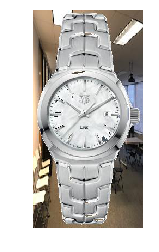

In [21]:
starting_name = np.random.choice(good_files)
img=mpimg.imread(starting_name)
imgplot = plt.imshow(img)
plt.axis('off')

In [22]:
n = 6

In [23]:
img = prepare_image(starting_name)
img = img/255

In [24]:
out = watch_model_headless.predict(img)
similarities = cosine_similarity(out,fvecs) 
top_matches = np.array(similarities).argpartition(-n)[0][-n:]

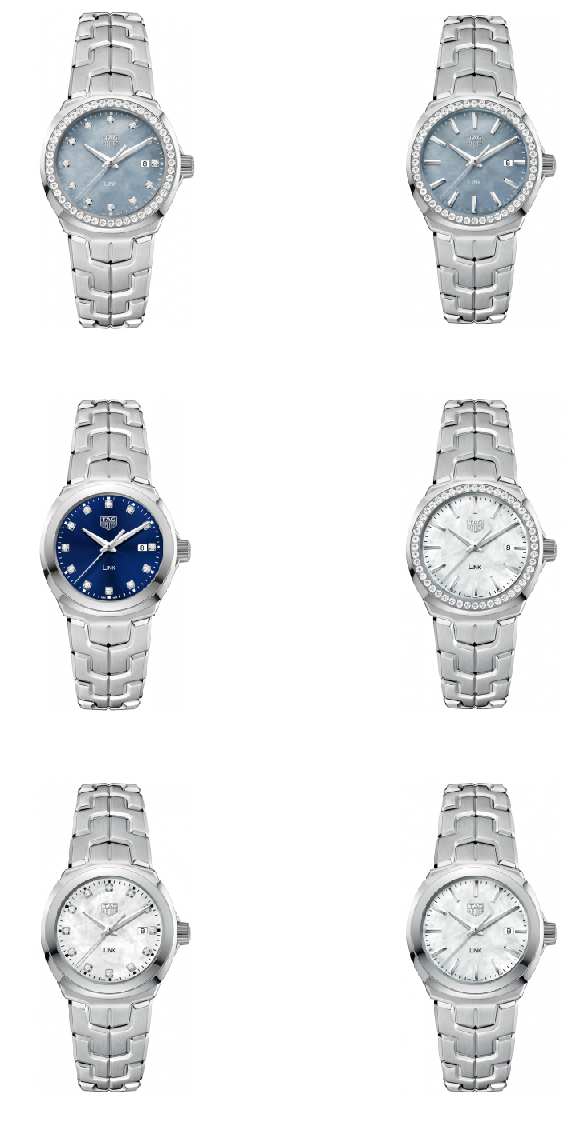

In [25]:
recommend_names = dist_df.columns[top_matches]

r = int(np.ceil(n/2))
c = 2
plt.subplots(nrows=r, ncols=c,figsize=(12,20))

for ix, f_name in enumerate(recommend_names):
    plt.subplot(r,c,ix+1)
    img_rec=mpimg.imread(f_path + f_name + '.jpg')
    imgplot = plt.imshow(img_rec)
    plt.axis('off')

Predict Intended Gender

In [26]:
starting_name_short = starting_name.split('_')[-1].split('/')[-1][:-4]

In [27]:
watch_df.loc[
    watch_df['image_name'] ==starting_name_short][['image_name','is_male']]

,image_name,is_male
10395,TagHeuerLinkQuartz32mmwbc1310ba0600,0


In [28]:
np.shape(img)

(1, 299, 299, 3)

In [29]:
out = watch_model.predict(img)
out

array([[ 0.00168688]], dtype=float32)

__ Open Random Pictures and Test Classification__

(-0.5, 1399.5, 1049.5, -0.5)

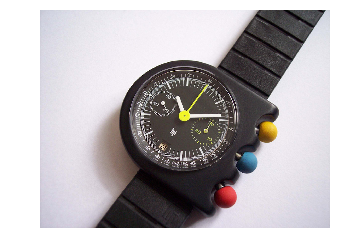

In [123]:
test_path = 'test_pics/'
test_files = os.listdir(test_path)

test_file = test_path + np.random.choice(test_files)
#test_file = test_path + 'blogger-image--2007922873.jpg' #
#test_file = test_path +'Bulgari-Octo-Finissimo-Automatic-Thinnest-Titanium-Sand-Blasted-2017-aBlogtoWatch-22.jpg'
#test_file = test_path +'cocktail_watch.JPG'
#test_file = test_path +'james_bonds_wrist.png'
#test_file = test_path +'ga054-omega-seamaster-planet-ocean-skyfall.jpg'

img2show=mpimg.imread(test_file)
imgplot = plt.imshow(img2show)
plt.axis('off')

In [124]:
img = prepare_image(test_file)
img = img/255
out = watch_model.predict(img)
print(out)

[[ 0.56295055]]


In [125]:
out = watch_model_headless.predict(img)
similarities = cosine_similarity(out,fvecs) 
top_matches = np.array(similarities).argpartition(-n)[0][-n:]

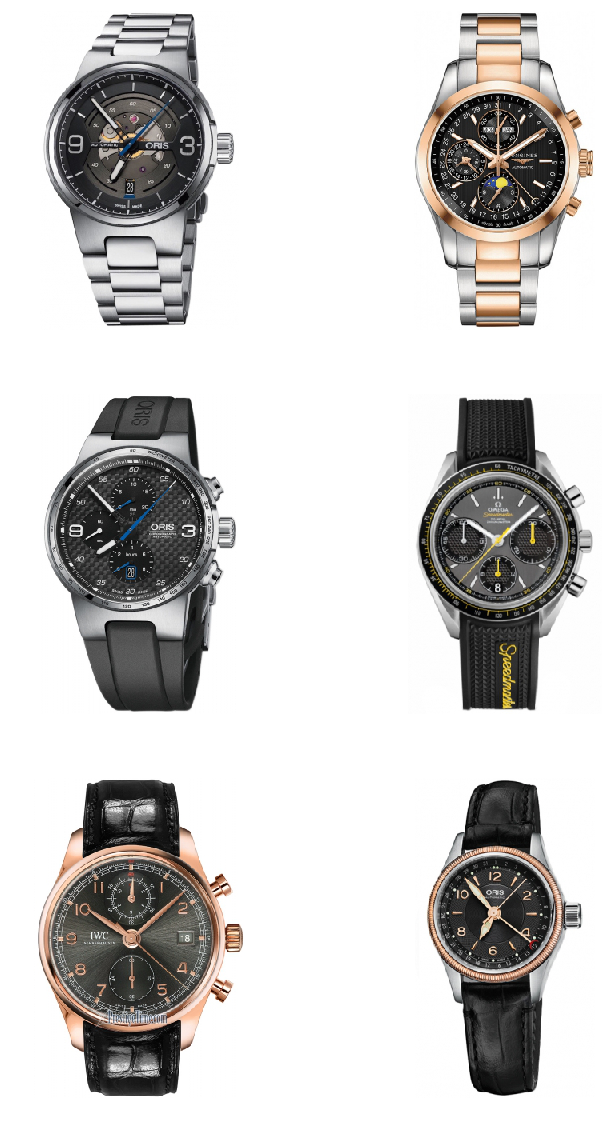

In [126]:
recommend_names = dist_df.columns[top_matches]

r = int(np.ceil(n/2))
c = 2
plt.subplots(nrows=r, ncols=c,figsize=(12,20))

for ix, f_name in enumerate(recommend_names):
    plt.subplot(r,c,ix+1)
    img_rec =mpimg.imread(f_path + f_name + '.jpg')
    imgplot = plt.imshow(img_rec)
    plt.axis('off')